In [3]:
%matplotlib inline
%config Completer.use_jedi = False

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

In [4]:
train_data = pd.read_excel("../../data/unzipped/Train.xlsx", skiprows=range(1,2), index_col=0, sheet_name=0)

In [5]:
train_data.head()

,"Диффузный индекс цен на выпускаемую продукцию, ожидаемые изменения","Диффузный индекс цен на покупаемую продукцию, ожидаемые изменения","Диффузный индекс заработной платы, ожидаемые изменения","Диффузный индекс занятости, ожидаемые изменения","Диффузный индекс выпуска, ожидаемые изменения","Диффузный индекс закупок оборудования, ожидаемые изменения","Диффузный индекс финансового состояния, ожидаемые изменения","Диффузный индекс портфеля заказов, ожидаемые изменения","Диффузный индекс задолженности банкам, ожидаемые изменения","Производство скота и птицы, тыс.тонн",...,"Среднемесячная пенсия, руб.",Реальная пенсия,MIACR,"Ставка по краткосрочным кредитам, население","Ставка по долгосрочным кредитам, население","Ставка по краткосрочным кредитам, фирмы","Ставка по долгосрочным кредитам, фирмы","Краткосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб","Долгосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб","Цена Urals, долл/бар"
2003m01,74,93,61,40,44,28,47,44,22,6.269096,...,7.288791,0.000000,6.331,21.5,18.9,14.5,17.3,6.993658,6.290272,3.383413
2003m02,78,95,66,37,49,30,53,56,18,6.320768,...,7.313953,0.008960,2.514,22.2,17.8,14.1,19.6,7.019476,6.298398,3.420624
2003m03,84,98,72,45,56,29,51,61,25,6.361302,...,7.314153,-0.001091,2.625,18.3,19.9,13.3,16.4,7.031299,6.325613,3.363693
2003m04,83,95,70,40,66,38,59,69,23,6.269096,...,7.382809,0.057178,1.888,20.0,21.3,13.4,14.9,7.048821,6.343001,3.130242
2003m05,79,94,76,43,66,33,63,68,23,6.177944,...,7.382809,0.049146,1.308,23.1,21.5,12.5,15.0,7.076400,6.371099,3.210488


In [248]:
from scipy.stats import norm
from sklearn.metrics import r2_score, mean_squared_error

def p_val(x):
    return 2 * min(norm.cdf(-x), norm.cdf(x))

def z_test(res1, res2):
    res2 = np.array(res2)
    res1 = np.array(res1)
    delta = res1 - res2
    mu_z = np.mean(delta)
    sigma = np.std(delta)
    z = mu_z / sigma * T ** 0.5
    p = p_val(z)
    win_rate = np.mean(res1 <= res2) 
    return {"p_value":p, "mu": mu_z, "sigma": sigma, "win_rate": win_rate}

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

In [8]:
def remove_nan_prefix(X):
    X = np.array(X, dtype=float)
    last_nan = np.max(list(np.where(np.isnan(X))[0]) + [-1])
    X = X[last_nan + 1:]
    return X

In [9]:
adfuller_vals = []
for i in range(train_data.shape[1]):
    X = train_data.values[:, i]
    X = remove_nan_prefix(X)
    decompose_result = seasonal_decompose(X, model="additive", period=12)

    trend = decompose_result.trend
    seasonal = decompose_result.seasonal
    residual = decompose_result.resid

    diff = X - seasonal
    diff = (diff - np.mean(diff)) / np.std(diff)
    result = adfuller(diff)
    adfuller_vals.append(result[1])

(array([5., 2., 2., 4., 2., 2., 4., 3., 1., 0., 1., 1., 3., 3., 1., 3., 4.,
        3., 1., 1., 2., 1., 0., 1., 2., 4., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 3.]),
 array([0.00127187, 0.02122641, 0.04118095, 0.06113549, 0.08109003,
        0.10104457, 0.12099911, 0.14095365, 0.16090819, 0.18086273,
        0.20081727, 0.22077181, 0.24072635, 0.26068089, 0.28063543,
        0.30058997, 0.32054451, 0.34049905, 0.36045359, 0.38040813,
        0.40036267, 0.42031721, 0.44027175, 0.4602263 , 0.48018084,
        0.50013538, 0.52008992, 0.54004446, 0.559999  , 0.57995354,
        0.59990808, 0.61986262, 0.63981716, 0.6597717 , 0.67972624,
        0.69968078, 0.71963532, 0.73958986, 0.7595444 , 0.77949894,
        0.79945348, 0.81940802, 0.83936256, 0.8593171 , 0.87927164,
        0.89922618, 0.91918072, 0.93913526, 0.9590898 , 0.97904434,
        0.99899888]),
 <BarContainer object of 50 artists>)

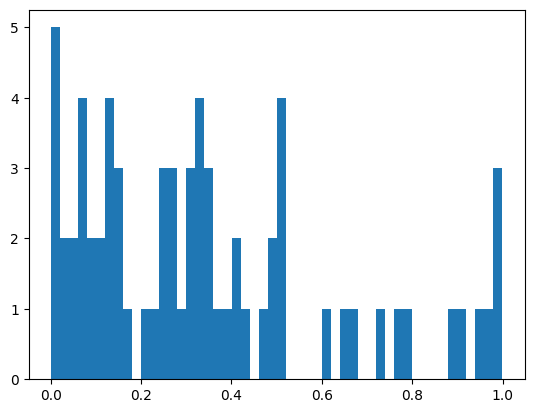

In [10]:
plt.hist(adfuller_vals, bins=50)

In [228]:
def total(wmsfes):
    scores = 0
    alpha = 12
    scores = []
    for m in wmsfes:
        score = (1.8 - 1.6 / (1 + np.exp(-alpha * m)))
        scores.append(score)
    return np.sum(scores) / len(wmsfes), scores


class Task:
    def __init__(self, history, orig, pred, period=12):
        assert period in [4,12]
        self.history = history
        self.orig = orig
        self.pred = pred
        self.period = period


def wmsfe(tasks):
    hm = np.array([len(t.orig) for t in tasks])
    km = np.sum(hm)
    scores = []
    for t in tasks:
        assert t is not None
        assert t.orig.shape == t.pred.shape
        disp = np.var(t.history[t.period:] - t.history[:-t.period])
        disp = np.nan_to_num(disp) + 1e-9
        score = np.sum((t.orig - t.pred) ** 2 / (np.arange(len(t.pred)) + 1)) / disp
        scores.append(score)
    return np.sum(scores) / km, scores / hm

class TaskSet:
    def __init__(self):
        self.groups = []
        
    def buildFromTasks(self, tasks2d):
        for g in tasks2d:
            self.addGroup()
            for t in g:
                self.addTask(t)
        return self

    def addTask(self, task):
        self.groups[-1].append(task)

    def addGroup(self):
        self.groups.append([])

    def calcScore(self):
        losses = []
        for g in self.groups:
            loss, _ = wmsfe(g)
            losses.append(loss)
        return total(losses)
    

def leaderboard(tasks2d):
    return TaskSet().buildFromTasks(tasks2d).calcScore()

In [229]:
window = None

In [230]:
class Normalizer:
    def __init__(self, period):
        self.period = period
        self.try_fallback = False
    
    def transform(self, X):
        X = remove_nan_prefix(X)
        l = X.shape[0]
        if l < 2 * self.period:
            assert False
            ft = 0 if l == 0 else X[0]
            X = np.array([float(ft)] * (3 * self.period - l) + list(X))
            self.try_fallback = True
        r = seasonal_decompose(X, model="additive", period=self.period)
        trend = X - r.seasonal
        
        mean = np.mean(trend)
        std = np.std(trend)
        trend_norm = (trend - mean) / (std + 1e-9)
        
        self.seasonal = r.seasonal
        self.mean = mean
        self.std = std
#         self.trend_model = trend_model
        return trend_norm
    def inverse(self, X):
        X *= self.std
        X += self.mean
        seasons = np.tile(self.seasonal, len(X) // len(self.seasonal) + 1)[:len(X)]
        X += seasons
        return X

In [231]:
class BaseModel:
    def fit(self, X, y):
        pass
    def predict(self, X):
        pass
    
class ZeroModel(BaseModel):
    def predict(self,_):
        return [0]

class LastConstModel(BaseModel):
    def predict(self, X):
        return [X[0][-1]]
    
class FirstConstModel(BaseModel):
    def __init__(self):
        self.const = None

    def predict(self, X):
        if self.const is None:
            self.const = X[0][-1]
        return [self.const]
    
class Weighted(BaseModel):
    def __init__(self, weights, base_model):
        self.weights = weights
        self.base_model = base_model
    def fit(self, X, y):
        return self.base_model.fit(X * self.weights, y)
    def predict(self, X):
        return self.base_model.predict(X * self.weights)
    
class Scaled(BaseModel):
    def __init__(self, weight, base_model):
        self.weight = weight
        self.base_model = base_model
    def fit(self, X, y):
        return self.base_model.fit(X, y)
    def predict(self, X):
        return self.base_model.predict(X) * self.weight
    
class PredictWithDelta(BaseModel):
    def __init__(self, base_model):
        self.base_model = base_model
    def predict(self, X):
        y = self.base_model.predict(X)
        return X[:, -1] + y

In [232]:
def add_cumulative_noise(X, weight=1e-2):
    assert len(X.shape) == 2 and isinstance(X, np.ndarray)
    Z = np.random.normal(size=X.shape)
    W = np.tile(np.arange(X.shape[0], 0, -1).reshape(-1,1), X.shape[1]) / X.shape[0] * weight
    Z = np.cumsum(Z, axis=0) * W
    return X * (1 + Z)

In [16]:
withNoise = add_cumulative_noise(train_data.values)

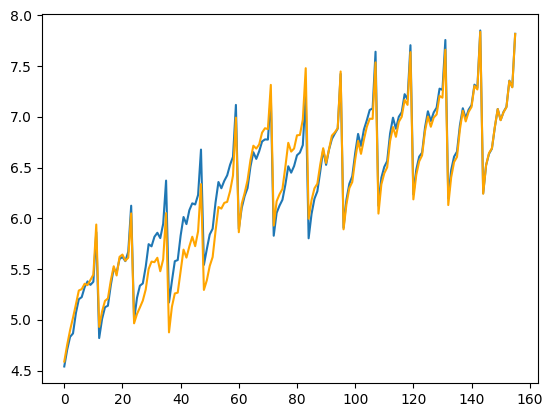

In [17]:
T = 15
plt.plot(train_data.values[:, T])
plt.plot(withNoise[:, T], "orange")

In [233]:
import tqdm

class SearchSequenceIndex:
    def __init__(self, window, period, offset):
        self.window = window
        self.period = period
        self.offset = offset
        
    def get_train_part_and_full(self, X, remove_prefix=0):
        train_gap = self.offset + self.period + self.window
        X = X[remove_prefix:]
        T = X[:-train_gap]
        return T, X
    
    def build(self, X):
        assert len(X.shape) == 2
        self.X_normed = []

        for i in np.arange(X.shape[1]):
            x = X[:, i]
            x = Normalizer(self.period).transform(x)
            for j in range(len(x) - self.window - 1):
                sample = x[j:j + self.window + 1]
                self.X_normed.append(sample)
        self.X_normed = np.array(self.X_normed)
    
    def fit(self, base_model):
        self.base_model = base_model
        X_train = np.array([x[:-1] for x in self.X_normed])
        y_train = np.array([x[-1] - x[-2] for x in self.X_normed])
        self.base_model.fit(X_train, y_train)
        self.base_model = PredictWithDelta(self.base_model)
        
    def predict_for_seq(self, seq, steps):
        assert len(seq.shape) == 1, seq.shape[0] >= 2 * self.window
        normalizer = Normalizer(self.period)
        seq = normalizer.transform(seq)
        for i in np.arange(steps):
            subSeq = seq[-self.window:]
            origSubSeq = subSeq
            x = subSeq.reshape(1,-1)
            if normalizer.try_fallback:
                y = PredictWithDelta(ZeroModel()).predict(x)[0]
            else:
                y = self.base_model.predict(x)[0]
            subSeq = list(subSeq) + [y]
            assert np.mean((subSeq[:-1] - origSubSeq) ** 2) < 1e-6, (subSeq, origSubSeq)
            seq = np.append(seq, subSeq[-1])
        seq = normalizer.inverse(seq)
        return seq

    def measure_on_all_train_data(self, X, offset):
        mse = 0
        N = len(X)
        tasks = []
        for t in np.arange(N):
            history = remove_nan_prefix(X[t])
            window_data = history[:-offset]
            r = self.predict_for_seq(window_data, offset)
            task = Task(window_data, history[-offset:], r[-offset:])
            tasks.append(task)
        return tasks
    
def index_series(X, window, period, model, step=1, noise_iters=0, noise_weight=1e-2, global_offset=15):
    np.random.seed(0)
    assert len(X.shape) == 2 and isinstance(X, np.ndarray)
    xlen = X.shape[0]
    scores = []
    losses = []
    use_noise = True if noise_iters > 0 else False
    noise_iters = max(1, noise_iters)
    for t in range(noise_iters):
        for offset in tqdm.tqdm(np.arange(0, xlen - 2 * (period + window + global_offset) - 1, step), position=0):
            index = SearchSequenceIndex(window, period, global_offset)
            T, F = index.get_train_part_and_full(X, offset)
            if use_noise:
                T = add_cumulative_noise(T, noise_weight)
            index.build(T)
            index.fit(model())
            res = index.measure_on_all_train_data(np.transpose(F), global_offset)
            mean_loss, _losses = wmsfe(res)
            score, scores = total(_losses)
            scores.extend(scores)
            losses.extend(_losses)
    return np.array(scores), np.array(losses)

In [252]:
zero_measures = index_series(
    train_data.values,
    window=12 * 3,
    period=12,
    model=lambda:ZeroModel(),
    step=6,
    noise_iters=3
)

knn_measures = index_series(
    train_data.values,
    window=12 * 3,
    period=12,
    model=lambda:Scaled(0.5, KNeighborsRegressor(n_neighbors=25)),
    step=6,
    noise_iters=3
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


In [254]:
np.mean(knn_measures[0]), np.mean(zero_measures[0]), z_test(knn_measures[0], zero_measures[0])

(0.353334634954126,
 0.34097475092624124,
 {'p_value': 0.34272837132226197,
  'mu': 0.01235988402788474,
  'sigma': 0.08341364003076952,
  'win_rate': 0.4782608695652174})

In [255]:
np.mean(knn_measures[1]), np.mean(zero_measures[1]), z_test(knn_measures[1], zero_measures[1])

(1.627452449251935,
 1.6973818018010343,
 {'p_value': 0.14253973259103841,
  'mu': -0.06992935254909906,
  'sigma': 0.30535104022556,
  'win_rate': 0.6483091787439613})

In [2645]:
train_data.values.shape

(156, 69)

knn:  1.537115321084865 0.3618363377327978
zero:  1.6253887423863334 0.3328912518292378
log z-test:  {'p_value': 0.003341037356848263, 'mu': 0.16949000110707418, 'sigma': 0.3698319237974208, 'win_rate': 0.6376811594202898}


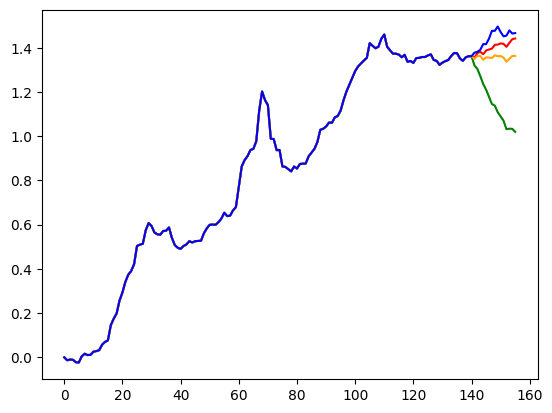

In [57]:
T = 41

offset = 15
index = SearchSequenceIndex(window=12 * 3, period=12, offset=offset)

pref, full = index.get_train_part_and_full(train_data.values)
index.build(pref)

orig = train_data.values[:, T]
window_data = orig[:-offset]

index.fit(Scaled(0.5, KNeighborsRegressor(n_neighbors=25)))
r1 = index.predict_for_seq(window_data, offset)
knn_res = index.measure_on_all_train_data(full.T, offset=offset)
knn_scores = wmsfe(knn_res)
print('knn: ', knn_scores[0], leaderboard([[x] for x in knn_res]))

index.fit(LinearRegression())
r2 = index.predict_for_seq(window_data, offset)

index.fit(ZeroModel())
r3 = index.predict_for_seq(window_data, offset)
zero_res = index.measure_on_all_train_data(full.T, offset=offset)
zero_scores = wmsfe(zero_res)

print('zero: ', zero_scores[0], leaderboard([[x] for x in zero_res]))

print('log z-test: ', log_z_test(knn_scores[1], zero_scores[1]))

plt.plot(r1, 'red')
plt.plot(r2, 'green')
plt.plot(r3, 'orange')
plt.plot(train_data.values[:, T], 'blue')
plt.show()

In [97]:
test_data = []
for i in range(14):
    test_data.append(pd.read_excel("../../data/unzipped/Test_example{}.xlsx".format(i+1), index_col=0))

In [98]:
test_data[0].values

array([[0, 6.331, 3.383412716909289, 0],
       [0.015873349156290163, 2.514, 3.4206241213279664,
        -0.017146158834970514],
       [0.026813289194624383, 2.625, 3.363693289509691,
        0.06166502158931933],
       [0.036763620047792434, 1.888, 3.130242353774201,
        0.05262427693717031],
       [0.04473178969696934, 1.308, 3.210487802387275,
        0.042573941083668874],
       [0.05269995934614613, 1.361, 3.240394998596765,
        0.047561482594707966],
       [0.059675573082571445, 3.618, 3.290427738053673,
        0.07420341354112908],
       [0.05566755168503258, 3.813, 3.366655230757925,
        0.1037622157826736],
       [0.05866306066483113, 9.78, 3.2485581852307597,
        0.11569078664794731],
       [0.06861339151799915, 4.787, 3.3441821800732363,
        0.1491255627341847],
       [0.07856372237116713, 3.327, 3.317510615564801,
        0.15510763441173203],
       [0.08950366240950142, 1.395, 3.347831766060903,
        0.29834180249763975],
       [0.107343

In [100]:
X = []
for i in range(14):
    for f in np.arange(test_data[i].shape[1]):
        seq = test_data[i].values[:, f]
        seq = seq[np.where(seq != "Forecast")]
        if len(seq) >= 12 * 5:
            X.append(seq)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [101]:
len([len(x) for x in X if len(x) >= 12 * 5]), len(X)

(58, 58)

In [104]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(train_data.values)

index.fit(Scaled(0.5, KNeighborsRegressor(n_neighbors=25)))
knn_res = index.measure_on_all_train_data(X, offset=15)
knn_scores = wmsfe(knn_res)
print('knn: ', knn_scores[0], leaderboard([[x] for x in knn_res]))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(X, offset=15)
zero_scores = wmsfe(zero_res)

print('zero: ', zero_scores[0], leaderboard([[x] for x in zero_res]))

print('log z-test: ', log_z_test(knn_scores[1], zero_scores[1]))

knn:  0.2056543541583501 0.433000535647555
zero:  0.2180429271995853 0.43177839979789956
log z-test:  {'p_value': 0.20441159393269148, 'mu': 0.021658642254940418, 'sigma': 0.10927813023140874, 'win_rate': 0.39655172413793105}


In [2410]:
quartal_data = pd.read_excel("../../data/unzipped/Train.xlsx", skiprows=range(1,2), index_col=0,sheet_name=1)

In [2411]:
quartal_data.head()

,"ВВП, млрд",Реальный ВВП,"ВВП A, млрд.руб.","ВВП B, млрд.руб.","ВВП C, млрд.руб.","ВВП D, млрд.руб.","ВВП E, млрд.руб.","ВВП F, млрд.руб.","ВВП G, млрд.руб.","ВВП H, млрд.руб.",...,Реальный ВВП K,Реальный ВВП L,Реальный ВВП M,Реальный ВВП N,Реальный ВВП O,Реальные налоги на продукты,Реальные субсидии на продукты,"Инвестиции, собственные средства, млрд.руб.","Инвестиции, привлеченные средства, млрд.руб.","Инвестиции, бюджетные средства, млрд.руб."
2003m03,8.041233,0.000000,4.273602,2.633625,5.134760,5.926435,4.786542,4.884884,6.374866,2.944192,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.872905,4.911183,3.832980
2003m06,8.115856,0.067384,4.520113,2.511972,5.133081,6.073957,4.461686,5.208554,6.393228,3.151690,...,0.032777,0.005775,-0.017488,0.016888,0.049110,0.047356,0.032027,5.249127,5.455748,4.391977
2003m09,8.255223,0.119733,5.690798,2.816459,5.328411,6.158050,4.357089,5.476453,6.477670,3.245579,...,0.042272,0.060595,0.019040,0.037533,0.096204,0.063358,0.211227,5.367843,5.540086,4.513055
2003m12,8.265189,0.171204,4.979387,2.691399,5.296727,6.212625,4.766878,5.468805,6.588304,3.254391,...,0.130738,0.090004,0.043583,0.019568,0.228176,0.100861,0.024644,5.668501,5.927459,4.940213
2004m03,8.250766,0.069902,4.356881,2.822974,5.633453,6.213559,5.063559,5.077852,6.491535,3.362732,...,-0.087127,0.037359,-0.001314,0.011056,0.069604,0.096598,-0.046582,5.017942,5.226284,3.910021


In [2416]:
quartal_data.values.shape

(52, 39)

In [2485]:
index = SearchSequenceIndex(window=4 * 3, period=4, offset=5)
index.build(quartal_data.values)

T = 30
offset = 5
orig = quartal_data.values[:, T]
window_data = orig[:-offset]

index.fit(KNeighborsRegressor(n_neighbors=25))
r1 = index.predict_for_seq(window_data, offset)
knn_res = index.measure_on_all_train_data(quartal_data.values, offset=5)

(1521, 12) (1521,)


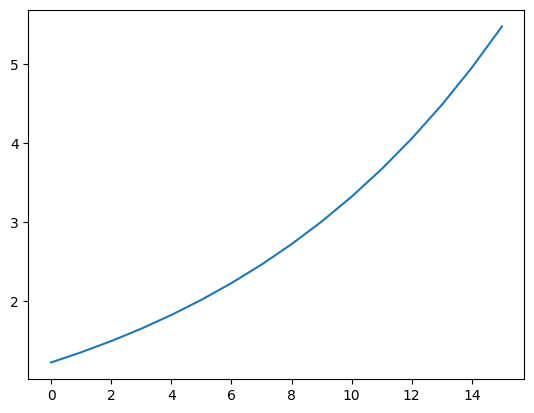

In [2627]:
windowq = 4 * 4
knn_weights_q = np.exp((np.arange(windowq).reshape(1, -1) + 2) * 0.1)
# knn_weights_q = np.ones(windowq).reshape(1,-1)
plt.plot(knn_weights_q.reshape(-1))

In [2628]:
from sklearn.linear_model import RANSACRegressor

In [2634]:
zero_measures = index_series(
    quartal_data.values,
    window=windowq,
    period=4,
    model=lambda:ZeroModel(),
    step=1,
    noise_iters=0,
    global_offset=5
)

knn_measures = index_series(
    quartal_data.values,
    window=windowq,
    period=4,
    model=lambda:Scaled(1e-2, RANSACRegressor()),
    step=1,
    noise_iters=0,
    global_offset=5
)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.73it/s]


In [2635]:
log_z_test(knn_measures[1], zero_measures[1])

{'p_value': 0.08087057578252001,
 'mu': 0.011064547853810213,
 'sigma': 0.034716456551465616,
 'win_rate': 0.717948717948718}

In [2636]:
np.mean(knn_measures[0]), np.mean(zero_measures[0])

(0.30560364936142254, 0.30358177014828686)

In [86]:
fred_month = pd.read_csv("fred_md.csv", skiprows=range(1,2), index_col=0)

In [87]:
fred_month.head(10)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2/1/1959,2451.778,2301.5,17.452,294424.7425,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3/1/1959,2467.594,2318.5,17.617,293418.6704,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4/1/1959,2483.671,2334.9,17.553,299322.8039,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5/1/1959,2498.026,2350.4,17.765,301364.3249,18679.66354,23.6050,24.4032,23.1398,32.4728,19.6670,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN
6/1/1959,2505.788,2357.4,17.831,301348.7981,18849.75209,23.6319,24.5755,23.3052,32.3184,19.8141,...,17.817,11.463,2.17,2.50,2.09,NaN,6956.0,12926.0,78.6972,NaN
7/1/1959,2504.312,2355.6,17.770,305020.3394,18843.52934,23.0660,24.6042,23.4983,32.7431,20.2064,...,17.835,11.504,2.17,2.51,2.09,NaN,7132.0,13199.0,78.9984,NaN
8/1/1959,2490.236,2342.1,17.877,289435.4569,18963.83587,22.2846,24.4319,23.4431,32.7817,19.6424,...,17.869,11.538,2.17,2.53,2.07,NaN,7309.0,13471.0,77.3045,NaN
9/1/1959,2492.033,2342.1,18.057,293697.8125,18715.96293,22.2577,24.3171,23.3604,32.6659,19.0539,...,17.916,11.572,2.17,2.54,2.08,NaN,7393.0,13657.0,76.8926,NaN


In [128]:
dates = []

for m in range(1,13):
    for y in range(2000, 2015):
        dates.append('{}/1/{}'.format(m, y))
        
fred = fred_month[fred_month.index.isin(dates)]

In [129]:
fred = np.log(1 + np.abs(np.nan_to_num(fred)))

In [130]:
fred.shape

(180, 127)

In [116]:
np.sum(np.isnan(fred))

0

In [137]:
infl_rate = pd.read_csv("../../data/infl_rate.csv")
infl_rate.head()

,Unnamed: 0,date,infl_rate
0,0,2003m01,2.40
1,1,2003m02,1.63
2,2,2003m03,1.05
3,3,2003m04,1.02
4,4,2003m05,0.80


In [138]:
key_rate = pd.read_csv("../../data/key_rate.csv")
key_rate.head()

,Unnamed: 0,date,key_rate
0,0,2003m01,21.000000
1,1,2003m02,19.714286
2,2,2003m03,18.000000
3,3,2003m04,18.000000
4,4,2003m05,18.000000


In [143]:
fred.shape

(180, 127)

In [145]:
np.array([np.nan] * (fred.shape[0] - infl_rate.shape[0]) + list(infl_rate['infl_rate'].values)).reshape(-1, 1).shape

(180, 1)

In [146]:
fred_with_ru = np.concatenate([
    fred,
    np.array([np.nan] * (fred.shape[0] - infl_rate.shape[0]) + list(infl_rate['infl_rate'].values)).reshape(-1, 1),
    np.array([np.nan] * (fred.shape[0] - key_rate.shape[0]) + list(key_rate['key_rate'].values)).reshape(-1, 1)
], axis=1)

In [147]:
fred_with_ru.shape

(180, 129)

In [134]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(fred)

index.fit(Scaled(0.5, KNeighborsRegressor(n_neighbors=25)))
knn_res = index.measure_on_all_train_data(X, offset=15)
knn_scores = wmsfe(knn_res)
print('knn: ', knn_scores[0], leaderboard([[x] for x in knn_res]))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(X, offset=15)
zero_scores = wmsfe(zero_res)

print('zero: ', zero_scores[0], leaderboard([[x] for x in zero_res]))

print('log z-test: ', log_z_test(knn_scores[1], zero_scores[1]))

knn:  0.19684318894057248 0.4302762509225455
zero:  0.2180429271995853 0.43177839979789956
log z-test:  {'p_value': 0.20298146239342918, 'mu': 0.040388903122971845, 'sigma': 0.20313764565829603, 'win_rate': 0.5344827586206896}


In [251]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(fred_with_ru)

index.fit(Scaled(0.5, KNeighborsRegressor(n_neighbors=25)))
knn_res = index.measure_on_all_train_data(X, offset=15)
_, knn_losses = wmsfe(knn_res)
_, knn_scores = total(knn_losses)
print('knn: ', np.mean(knn_scores), np.mean(knn_losses))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(X, offset=15)
_, zero_losses = wmsfe(zero_res)
_, zero_scores = total(zero_losses)
print('zero: ', np.mean(zero_scores), np.mean(zero_losses))

print('log z-test scores: ', z_test(knn_scores, zero_scores))
print('log z-test loss: ', z_test(knn_losses, zero_losses))

knn:  0.43031047981609316 0.19680388901451837
zero:  0.43177839979789945 0.21804292719958535
log z-test scores:  {'p_value': 0.6740111322755803, 'mu': -0.001467919981806356, 'sigma': 0.02234467595742505, 'win_rate': 0.46551724137931033}
log z-test loss:  {'p_value': 0.12560252872162575, 'mu': -0.021239038185066974, 'sigma': 0.08878917193105162, 'win_rate': 0.5344827586206896}


In [158]:
from sklearn.neural_network import MLPRegressor

In [186]:
windowm = 12 * 3

In [218]:
reg = MLPRegressor(hidden_layer_sizes = (windowm, 16, 8, 16, windowm), 
                   activation = 'tanh', 
                   solver = 'adam',
#                    learning_rate_init = 0.0001, 
#                    max_iter = 20, 
#                    tol = 0.0000001, 
                   verbose = True)

In [219]:
def encoder(reg, data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)

In [220]:
class AutoencKnnWrapper(BaseModel):
    def __init__(self, enc, knn):
        self.enc = enc
        self.knn = knn
    def fit(self, X, y):
        ids = np.arange(len(X))
        self.enc.fit(X, X)
        X_enc = encoder(self.enc, X)
        print(X_enc.shape)
        self.knn.fit(X_enc, y)
    def predict(self, X):
        X_enc = encoder(self.enc, X)
        return self.knn.predict(X_enc)

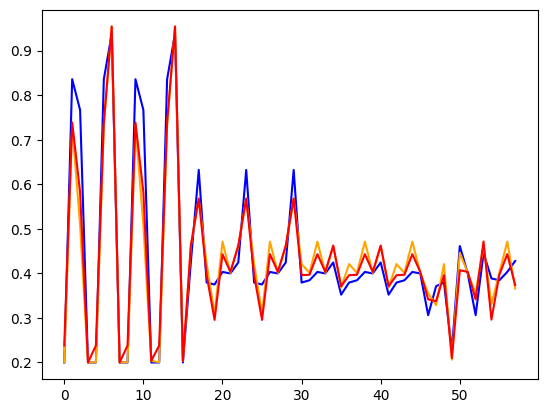

In [250]:
plt.plot(scores, 'blue')
plt.plot(zero_scores, 'orange')
plt.plot(knn_scores, 'red')

In [249]:
np.random.seed(0)

index.fit(AutoencKnnWrapper(autoenc, KNeighborsRegressor(n_neighbors=25)))
res = index.measure_on_all_train_data(X, offset=15)
scores = wmsfe(res)
_, losses = wmsfe(res)
_, scores = total(losses)

print('autoenc + knn: ', np.mean(scores), np.mean(losses))
print('log z-test scores: ', z_test(scores, zero_scores))
print('log z-test loss: ', z_test(losses, zero_losses))

Iteration 1, loss = 0.47548537
Iteration 2, loss = 0.43344459
Iteration 3, loss = 0.37748486
Iteration 4, loss = 0.31348833
Iteration 5, loss = 0.26913071
Iteration 6, loss = 0.23445389
Iteration 7, loss = 0.20424686
Iteration 8, loss = 0.17941109
Iteration 9, loss = 0.16020046
Iteration 10, loss = 0.14544486
Iteration 11, loss = 0.13295057
Iteration 12, loss = 0.11953852
Iteration 13, loss = 0.10149780
Iteration 14, loss = 0.08630993
Iteration 15, loss = 0.07638190
Iteration 16, loss = 0.06910964
Iteration 17, loss = 0.06301695
Iteration 18, loss = 0.05773572
Iteration 19, loss = 0.05411382
Iteration 20, loss = 0.05222400
Iteration 21, loss = 0.05112064
Iteration 22, loss = 0.05032978
Iteration 23, loss = 0.04969963
Iteration 24, loss = 0.04910903
Iteration 25, loss = 0.04841054
Iteration 26, loss = 0.04758240
Iteration 27, loss = 0.04669297
Iteration 28, loss = 0.04565949
Iteration 29, loss = 0.04438714
Iteration 30, loss = 0.04279426
Iteration 31, loss = 0.04076959
Iteration 32, los

In [227]:
total(wmsfe(res)[1])

0.4378064135481211

In [222]:
total(res[1])

TypeError: 'Task' object is not iterable

In [217]:
scores[1], knn_scores[1], zero_scores[1]

(array([5.49229806, 0.03468886, 0.0500512 , 2.26779055, 5.49229806,
        0.03468886, 0.01303926, 2.26779055, 5.49229806, 0.03468886,
        0.0500512 , 1.58604194, 5.49229806, 0.03468886, 0.01303926,
        1.58604194, 0.15103258, 0.08284402, 0.17242801, 0.17474222,
        0.16064004, 0.16221249, 0.15103258, 0.08284402, 0.17242801,
        0.17474222, 0.16064004, 0.16221249, 0.15103258, 0.08284402,
        0.17242801, 0.16979445, 0.16064004, 0.16221249, 0.15103258,
        0.1877105 , 0.17242801, 0.16979445, 0.16064004, 0.16221249,
        0.15103258, 0.1877105 , 0.17242801, 0.16979445, 0.16064004,
        0.16221249, 0.22031836, 0.17684407, 0.17242801, 0.33812365,
        0.13609074, 0.16221249, 0.22031836, 0.14240184, 0.16770206,
        0.16979445, 0.16064004, 0.14963709]),
 array([0.30937801, 0.05650857, 0.09658407, 0.88591061, 0.30937801,
        0.05650857, 0.00954596, 0.88591061, 0.30937801, 0.05650857,
        0.09658407, 0.50324446, 0.30937801, 0.05650857, 0.00954596,
  

In [214]:
print('log z-test: ', log_z_test(scores[1], zero_scores[1]))

log z-test:  {'p_value': 0.06539706068474933, 'mu': -0.18561526224977598, 'sigma': 0.645045089201634, 'win_rate': 0.27586206896551724}


In [185]:
np.random.seed(0)

index.fit(MLPRegressor(verbose=1, hidden_layer_sizes=[16, 16]))
res = index.measure_on_all_train_data(X, offset=15)
scores = wmsfe(res)

print('mlp: ', scores[0], leaderboard([[x] for x in res]))

Iteration 1, loss = 0.02910695
Iteration 2, loss = 0.02452074
Iteration 3, loss = 0.02363760
Iteration 4, loss = 0.02308965
Iteration 5, loss = 0.02268831
Iteration 6, loss = 0.02244219
Iteration 7, loss = 0.02218713
Iteration 8, loss = 0.02205334
Iteration 9, loss = 0.02181103
Iteration 10, loss = 0.02166923
Iteration 11, loss = 0.02154899
Iteration 12, loss = 0.02143700
Iteration 13, loss = 0.02131479
Iteration 14, loss = 0.02114396
Iteration 15, loss = 0.02105235
Iteration 16, loss = 0.02087198
Iteration 17, loss = 0.02070296
Iteration 18, loss = 0.02055883
Iteration 19, loss = 0.02047770
Iteration 20, loss = 0.02029292
Iteration 21, loss = 0.02015659
Iteration 22, loss = 0.02001556
Iteration 23, loss = 0.01997068
Iteration 24, loss = 0.01978429
Iteration 25, loss = 0.01971371
Iteration 26, loss = 0.01962922
Iteration 27, loss = 0.01953535
Iteration 28, loss = 0.01949330
Iteration 29, loss = 0.01932156
Iteration 30, loss = 0.01919053
Iteration 31, loss = 0.01913469
Iteration 32, los

In [181]:
print('log z-test: ', log_z_test(scores[1], zero_scores[1]))

log z-test:  {'p_value': 0.8140795045546758, 'mu': 0.023751983590027954, 'sigma': 0.6467200922261478, 'win_rate': 0.5344827586206896}


In [162]:
nn = MLPRegressor(verbose=1)
nn.fit(np.random.random((20,10)), np.random.random(20))

Iteration 1, loss = 0.19269964
Iteration 2, loss = 0.16789095
Iteration 3, loss = 0.14573109
Iteration 4, loss = 0.12643768
Iteration 5, loss = 0.10993654
Iteration 6, loss = 0.09618411
Iteration 7, loss = 0.08505438
Iteration 8, loss = 0.07638140
Iteration 9, loss = 0.07004289
Iteration 10, loss = 0.06570807
Iteration 11, loss = 0.06308641
Iteration 12, loss = 0.06182902
Iteration 13, loss = 0.06152731
Iteration 14, loss = 0.06178664
Iteration 15, loss = 0.06224091
Iteration 16, loss = 0.06264828
Iteration 17, loss = 0.06275087
Iteration 18, loss = 0.06240729
Iteration 19, loss = 0.06158548
Iteration 20, loss = 0.06032077
Iteration 21, loss = 0.05869232
Iteration 22, loss = 0.05677532
Iteration 23, loss = 0.05469439
Iteration 24, loss = 0.05254449
Iteration 25, loss = 0.05044509
Iteration 26, loss = 0.04846947
Iteration 27, loss = 0.04666424
Iteration 28, loss = 0.04506771
Iteration 29, loss = 0.04368951
Iteration 30, loss = 0.04252523
Iteration 31, loss = 0.04153246
Iteration 32, los

MLPRegressor(verbose=1)

In [161]:
nn

MLPRegressor()